## Importing Libraries

In [ ]:
import tensorflow as tf
import os
import PIL
from tensorflow.keras import datasets, layers, models
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
#import visualkeras
from keras.applications import InceptionV3
from tensorflow.keras import datasets,models,layers,Sequential
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def plot_metrics(history,title) :

    """ Plots training and validation loss and accuracy curves for a given training history.

  Args:
      history: A dictionary containing the training history returned by a Keras model's `fit` method.
          It should contain keys like 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.
      title: The title to display on the plots.

  Returns:
      None. This function displays the loss and accuracy plots and does not return any value.
  """

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    index_acc = np.argmax(val_acc)
    val_lowest = val_loss[index_loss]
    val_highest = val_acc[index_acc]

    epochs = [i+1 for i in range(len(train_acc))]
    loss_label = f'Best Epoch = {str(index_loss + 1)}'
    acc_loss = f'Best Epoch = {str(index_acc +1)}'

    #Training Accuracy
    plt.figure(figsize= (20,8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1,2,1)
    plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
    plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
    plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
    plt.title(f'{title} (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
    plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
    plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
    plt.title(f'{title} (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    # Save the plot as a PNG file
    plt.savefig(title + '.png')
    plt.show()

In [ ]:
def image_to_array(directory, image_size , info=False):

    """Loads, resizes, and normalizes images from a directory, and encodes labels.

  Args:
      directory: The path to the directory containing subfolders for each image category.
      image_size: A tuple (width, height) for resizing the images.
      info (bool, optional): If True, prints information about the loaded images and classes. Defaults to False.

  Returns:
      A tuple of NumPy arrays (data, labels, encoded_labels):
          - data: A 4D array of shape (num_images, image_height, image_width, channels) containing the normalized images.
          - labels: A 1D array of shape (num_images) containing the original category labels as strings.
          - encoded_labels: A 1D array of shape (num_images) containing the encoded numerical labels.
  """

    data = []
    labels = []
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)
        label = category
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)
            # reading and resizing
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            # normalising images
            image_array = image_array / 255.0
            data.append(image_array)
            labels.append(label)
    # label encoding
    encoded_lab = le.fit_transform(labels)
    # print information about data :
    if info :
        print(f"{len(data)} images found coming from {len(set(labels))} classes")
    return np.array(data),np.array(labels),np.array(encoded_lab)

In [ ]:
def compare_models(history_list,labels) :
    """Plots validation accuracy and loss curves for comparison of multiple models.

  Args:
      history_list: A list of training history objects returned by Keras models' `fit` method.
          Each history object should contain keys like 'val_accuracy' and 'val_loss'.
      labels: A list of labels for each model in `history_list`. These labels will be used in the plots.

  Returns:
      None. This function creates a Matplotlib figure with subplots displaying the curves and does not return a value.
  """

    plt.figure(figsize= (20,8))
    plt.suptitle("Comparing Models Performances", fontsize=16)
    i = 0
    for history in history_list :
        plt.subplot(1,2,1)
        plt.plot(history.history["val_accuracy"],label=f"{labels[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.xlim(0,7)
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(history.history["val_loss"],label=f"{labels[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.xlim(0,7)
        plt.legend()
        i += 1

    # Save the plot as a PNG file
    plt.savefig("Comparing Models Performances.png")

In [ ]:
def compare_conf_mat(models,test_img ,test_lbl, titles) :

    """Generates and compares confusion matrices for multiple models on a given test set.

  Args:
      models: A list of Keras models to compare.
      test_img: A NumPy array of test images.
      test_lbl: A NumPy array of corresponding test labels.
      titles: A list of titles for each model's confusion matrix subplot.

  Returns:
      None. This function creates a Matplotlib figure with subplots displaying confusion matrices and does not return a value.
  """
    labels = list(encoded_categories)
    plt.figure(figsize=(20, 10))
    i = 1
    for model in models :
        predictions = model.predict(test_img)
        # Convert predictions to class labels
        predicted_classes = np.argmax(predictions, axis=1)
        cm = confusion_matrix(test_lbl, predicted_classes)
        plt.subplot(2,3,i)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{titles[i-1]} Confusion Matrix")
        i+=1
    # Save the plot as a PNG file
    plt.savefig("Confusion Matrix.png")

In [ ]:
def plot_predictions(model,title) :
    """Visualizes a model's predictions on a sample of images.

  Args:
      model: A trained Keras model capable of image classification.
      title: A string to be used as the overall title of the plot.

  Returns:
      None. This function creates a Matplotlib figure displaying images and predictions and does not return a value.
  """
    pred_images = []

    # looping through our prediction data and transforming in it into array format
    for image_name in os.listdir(pred_dir)[30:40]:
                image_path = os.path.join(pred_dir, image_name)
                # reading and resizing
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                # normalising images
                image_array = image_array / 255.0
                pred_images.append(image_array)
    pred_images = np.array(pred_images)

    # getting the prediction array
    predictions = model.predict(pred_images)
    predictions_indices = np.argmax(predictions, axis = 1)

    # plotting our image predictions
    fig,ax = plt.subplots(2,5,figsize=(15,7))
    i = 0
    plt.style.use('ggplot')
    plt.suptitle(title)
    for image in pred_images :
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.title(encoded_categories[predictions_indices[i]])
        plt.grid(False)
        i+=1
    # Save the plot as a PNG file
    plt.savefig(title+ ".png")

## Importing data from kaggle

In [ ]:
file_url = 'https://raw.githubusercontent.com/shubhamvm/MScDataScience/main/MachineLearningNeuralNetworks/Assignments/Assignment1/kaggle.json'

# Download the file from the URL
response = requests.get(file_url)
file_content = response.content

# Save the content to a file in the /content/ directory
file_path = '/content/kaggle.json'
with open(file_path, 'wb') as file:
    file.write(file_content)

# Move the file to the appropriate location
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

# Set appropriate permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify that the file is successfully moved
print("File moved to:", '/root/.kaggle/kaggle.json')

!kaggle datasets download -d puneet6060/intel-image-classification


File moved to: /root/.kaggle/kaggle.json
 98% 339M/346M [00:04<00:00, 44.2MB/s]
100% 346M/346M [00:04<00:00, 82.0MB/s]


In [ ]:
#Extracting data
zip_path = '/content/intel-image-classification.zip'
extract_path = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted directory
extracted_contents = os.listdir(extract_path)
print(extracted_contents)

['seg_train', 'seg_pred', 'seg_test']


In [ ]:
# Initialising data
train_dir = '/kaggle/working/seg_train/seg_train'
test_dir = '/kaggle/working/seg_test/seg_test'
pred_dir = "/kaggle/working/seg_pred/seg_pred"
le = preprocessing.LabelEncoder()
classes = 6
image_size = (150,150)

## Data Preprocessing

In [ ]:
# trnsforming our images into array format
train_images, train_labels, train_lab_encoded = image_to_array(train_dir, image_size,True)
test_images, test_labels , test_lab_encoded = image_to_array(test_dir, image_size,True)
# getting the classes labels
encoded_categories = le.classes_

14034 images found coming from 6 classes
3000 images found coming from 6 classes


# Modelling :
In this part we will go through the different CNN version that we created from scratch and using transfer learning with different versions compare the results including fine-tuning :

* **Simple CNN**
* **Deep CNN**
* **Deep CNN + Fine-tuning**
* **Inception V1**
* **Inception V2**
* **Inception V3**

## I - Simple CNN :

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 128)               22429824  
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22431494 (85.57 MB)
Trainable params: 22431494 (85.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
model1.compile("adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_images, train_lab_encoded,
                    epochs=10,
                    validation_data=(test_images, test_lab_encoded))

In [ ]:
model1.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6823 - loss: 1.4031


[1.4325188398361206, 0.7006666660308838]

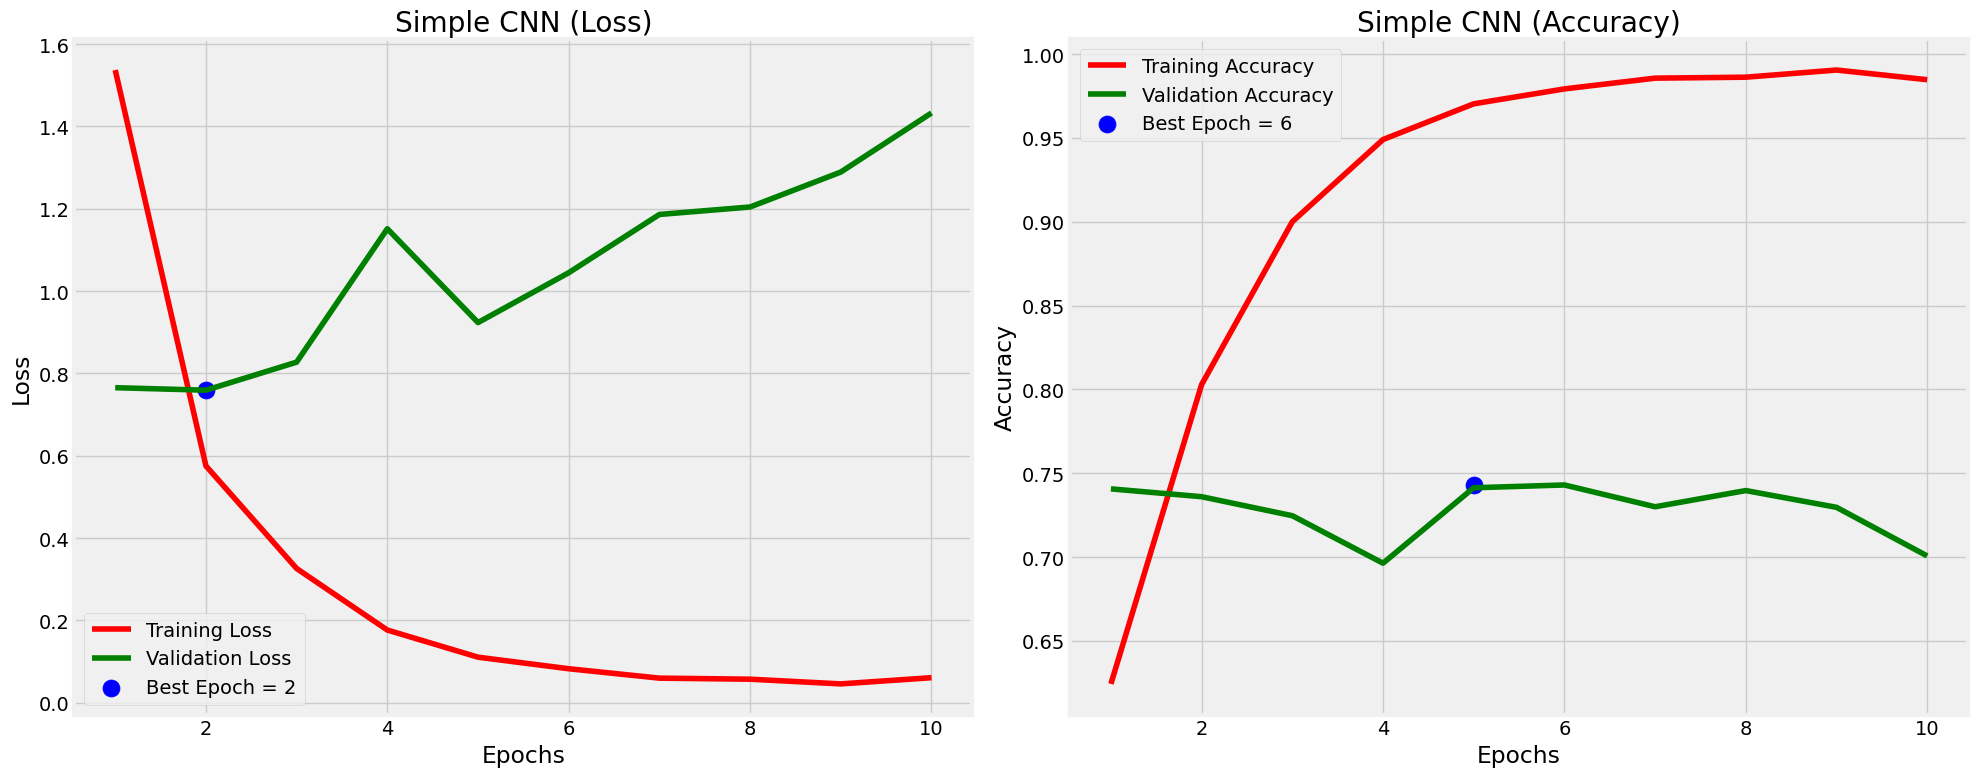

In [ ]:
plot_metrics(history1,"Simple CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


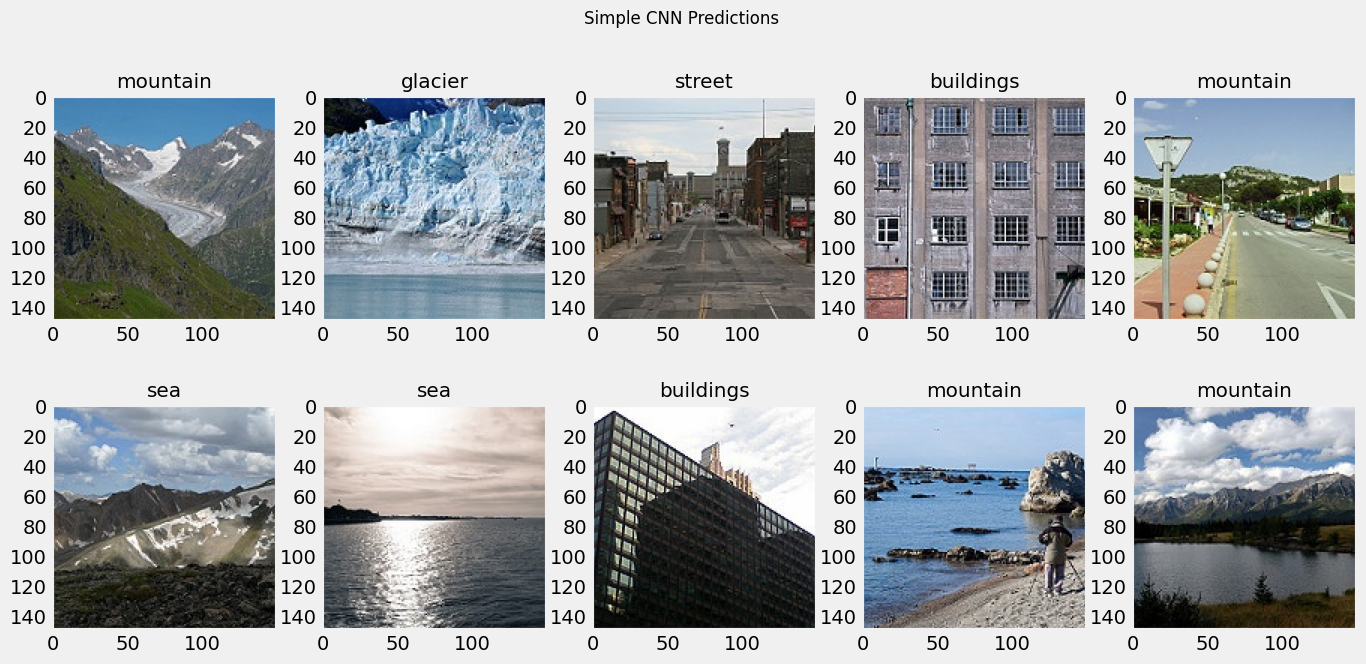

In [ ]:
plot_predictions(model1,"Simple CNN Predictions")

## II - Deep CNN :

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,086 (3.49 MB)

 Trainable params: 914,086 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile("adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_images, train_lab_encoded,
                    epochs=10,
                    validation_data=(test_images, test_lab_encoded))

Epoch 1/10
 13/439 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1650 - loss: 1.8523

W0000 00:00:1710593199.497518     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4736 - loss: 1.2778

W0000 00:00:1710593211.837288     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.4739 - loss: 1.2773 - val_accuracy: 0.6973 - val_loss: 0.8102
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7114 - loss: 0.7617 - val_accuracy: 0.7737 - val_loss: 0.6288
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7817 - loss: 0.5992 - val_accuracy: 0.7860 - val_loss: 0.6249
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8218 - loss: 0.4982 - val_accuracy: 0.7843 - val_loss: 0.6000
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8499 - loss: 0.3951 - val_accuracy: 0.8207 - val_loss: 0.5270
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8809 - loss: 0.3273 - val_accuracy: 0.8150 - val_loss: 0.5417
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8992 - loss: 0.2772 - val_accuracy: 0.8250 - val_loss: 0.5287
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9199 - loss: 0.2211 - val_accuracy: 0.81

In [ ]:
model2.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8110 - loss: 0.8158


[0.8015179634094238, 0.8143333196640015]

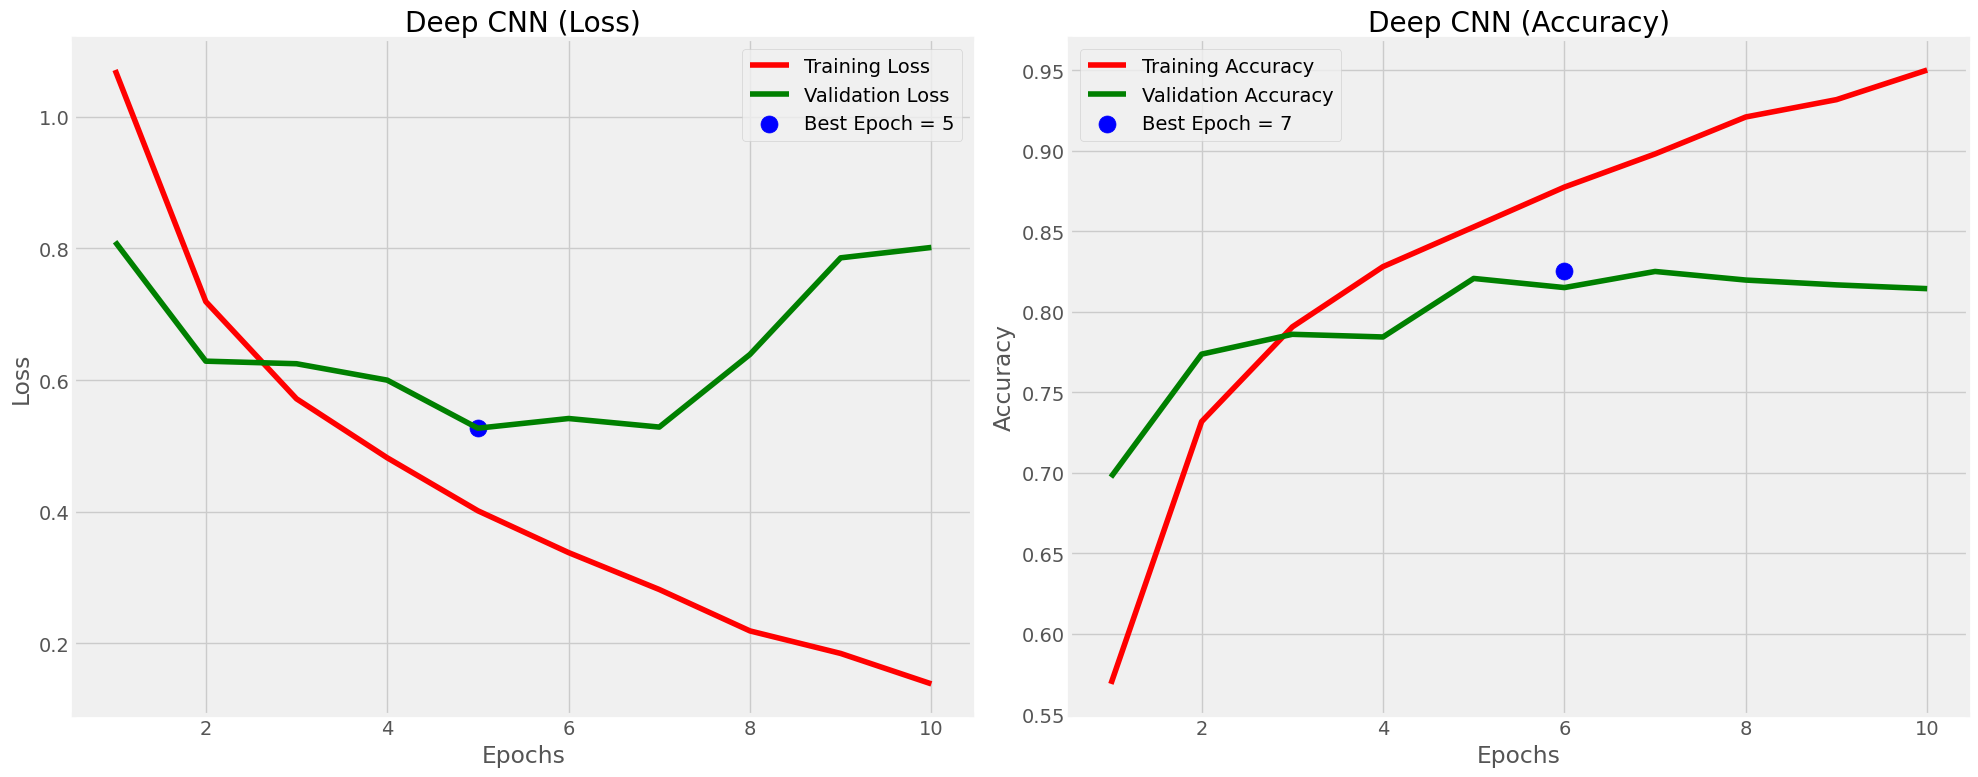

In [ ]:
plot_metrics(history2,"Deep CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


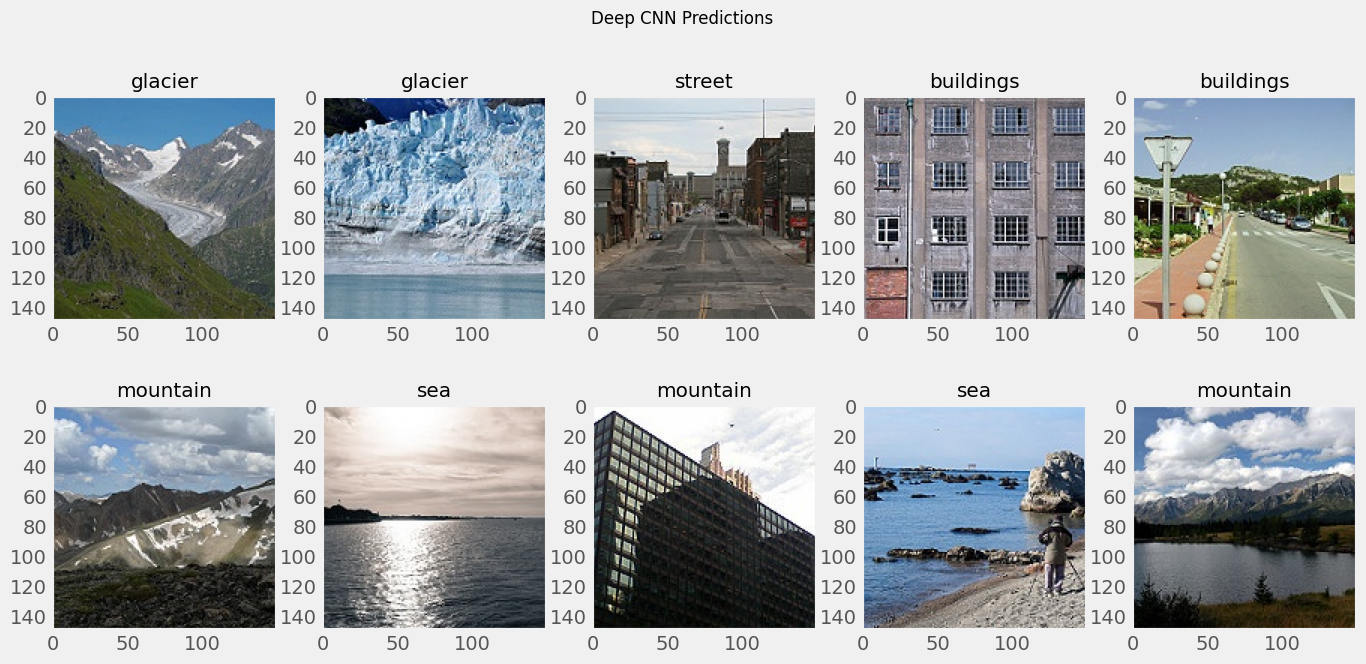

In [ ]:
plot_predictions(model2,"Deep CNN Predictions")

## III - Deep CNN + Fine-Tuning

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images.shape[1:]),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,750 (1.81 MB)

 Trainable params: 475,750 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(tf.keras.optimizers.Adamax() , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
# Train the model
history3 = model3.fit(train_images, train_lab_encoded,
                    epochs=20,
                    validation_data=(test_images, test_lab_encoded),
                    callbacks=[reduce_lr,early])

Epoch 1/20
 13/439 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2270 - loss: 1.8052

W0000 00:00:1710593302.139792     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4623 - loss: 1.3094

W0000 00:00:1710593310.729890     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710593313.307391     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.4625 - loss: 1.3090 - val_accuracy: 0.6203 - val_loss: 0.9497 - learning_rate: 0.0010
Epoch 2/20
  9/439 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6304 - loss: 0.9279

W0000 00:00:1710593314.566177     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6509 - loss: 0.8921 - val_accuracy: 0.7240 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7348 - loss: 0.7112 - val_accuracy: 0.7663 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7688 - loss: 0.6199 - val_accuracy: 0.7963 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7936 - loss: 0.5712 - val_accuracy: 0.7933 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8075 - loss: 0.5276 - val_accuracy: 0.8007 - val_loss: 0.5515 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8200 - loss: 0.5020 - val_accuracy: 0.8083 - val_loss: 0.5173 - learning_rate: 0.0010
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8307 - loss: 0.4653 - val_

In [ ]:
model3.evaluate(test_images,test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8212 - loss: 0.4904


[0.45716264843940735, 0.8376666903495789]

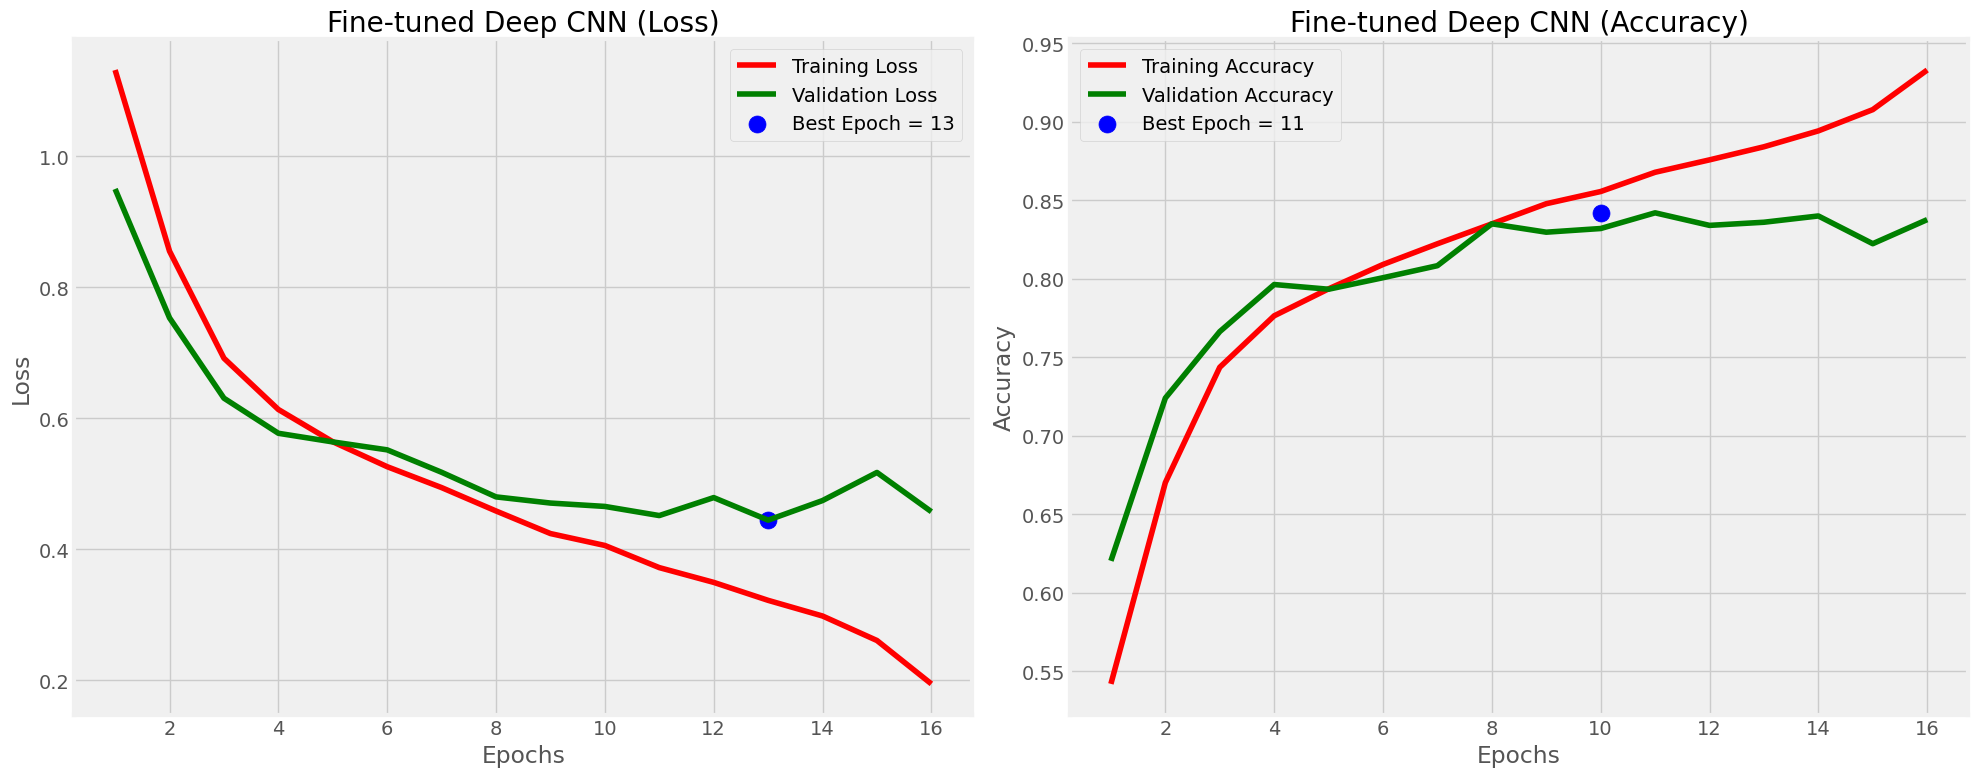

In [ ]:
plot_metrics(history3,"Fine-tuned Deep CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


W0000 00:00:1710593432.049443     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


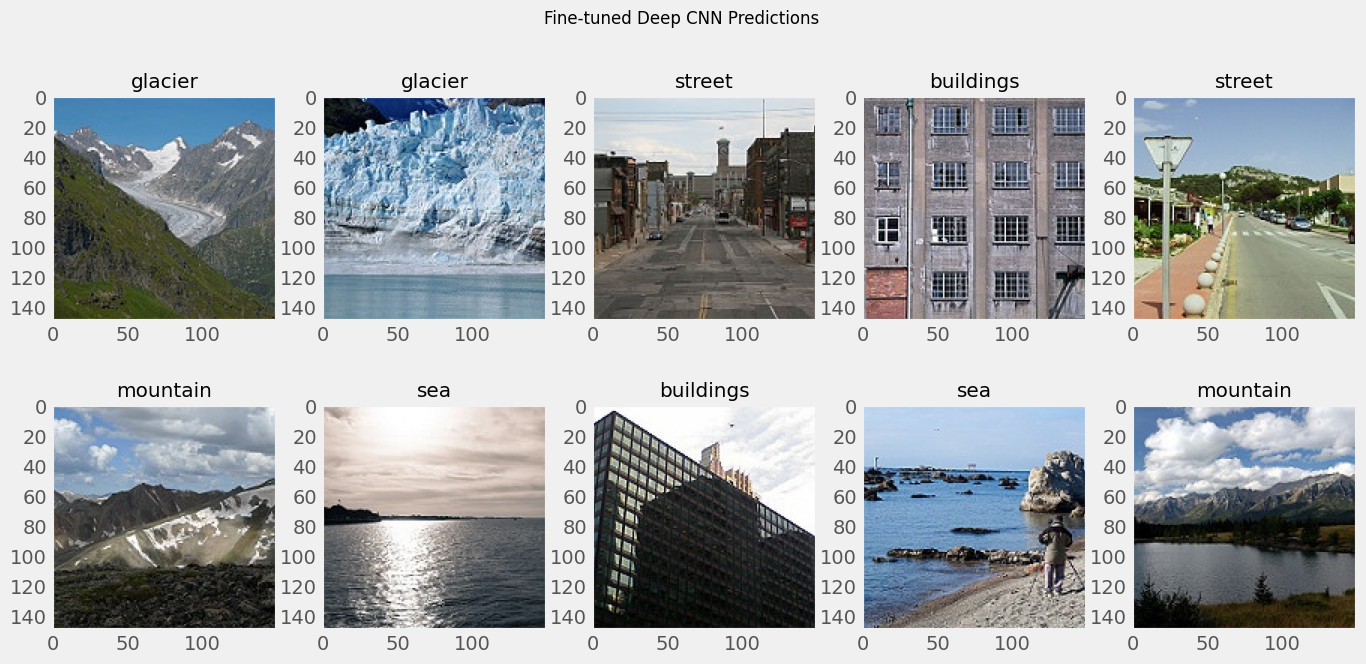

In [ ]:
plot_predictions(model3,"Fine-tuned Deep CNN Predictions")

## IV - Inception V1 :
This represents the first version of Inception

In [ ]:
# Load InceptionV3 pre-trained on ImageNet
inception1 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception1.layers:
    layer.trainable = False

# Unfreeze the last 25 layers for fine-tuning
for layer in inception1.layers[-25:]:
    layer.trainable = True

last_layer1 = inception1.get_layer('mixed7')
last_output1 = last_layer1.output

# Add custom classification head
x1 = layers.Flatten()(last_output1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)
pred1=layers.Dense(classes,activation="softmax")(x1)
# Create the fine-tuned model
model4 = models.Model(inputs=inception1.input, outputs=pred1)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# compile the model
model4.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history4 = model4.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
  5/439 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.3052 - loss: 1.7185 

W0000 00:00:1710593464.255592     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8399 - loss: 0.4456

W0000 00:00:1710593486.796015     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710593492.914527     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710593501.925179     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8400 - loss: 0.4454 - val_accuracy: 0.9053 - val_loss: 0.2704
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9421 - loss: 0.1683 - val_accuracy: 0.9153 - val_loss: 0.2354
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9596 - loss: 0.1247 - val_accuracy: 0.9140 - val_loss: 0.2564
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9767 - loss: 0.0793 - val_accuracy: 0.9160 - val_loss: 0.2348
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9842 - loss: 0.0601 - val_accuracy: 0.9153 - val_loss: 0.2529
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9942 - loss: 0.0333 - val_accuracy: 0.9133 - val_loss: 0.2728
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9959 - loss: 0.0279 - val_accuracy: 0.9153 - val_loss: 0.2611
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9980 - loss: 0.0190 - val_accurac

In [ ]:
model4.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9005 - loss: 0.2729


[0.23484864830970764, 0.9160000085830688]

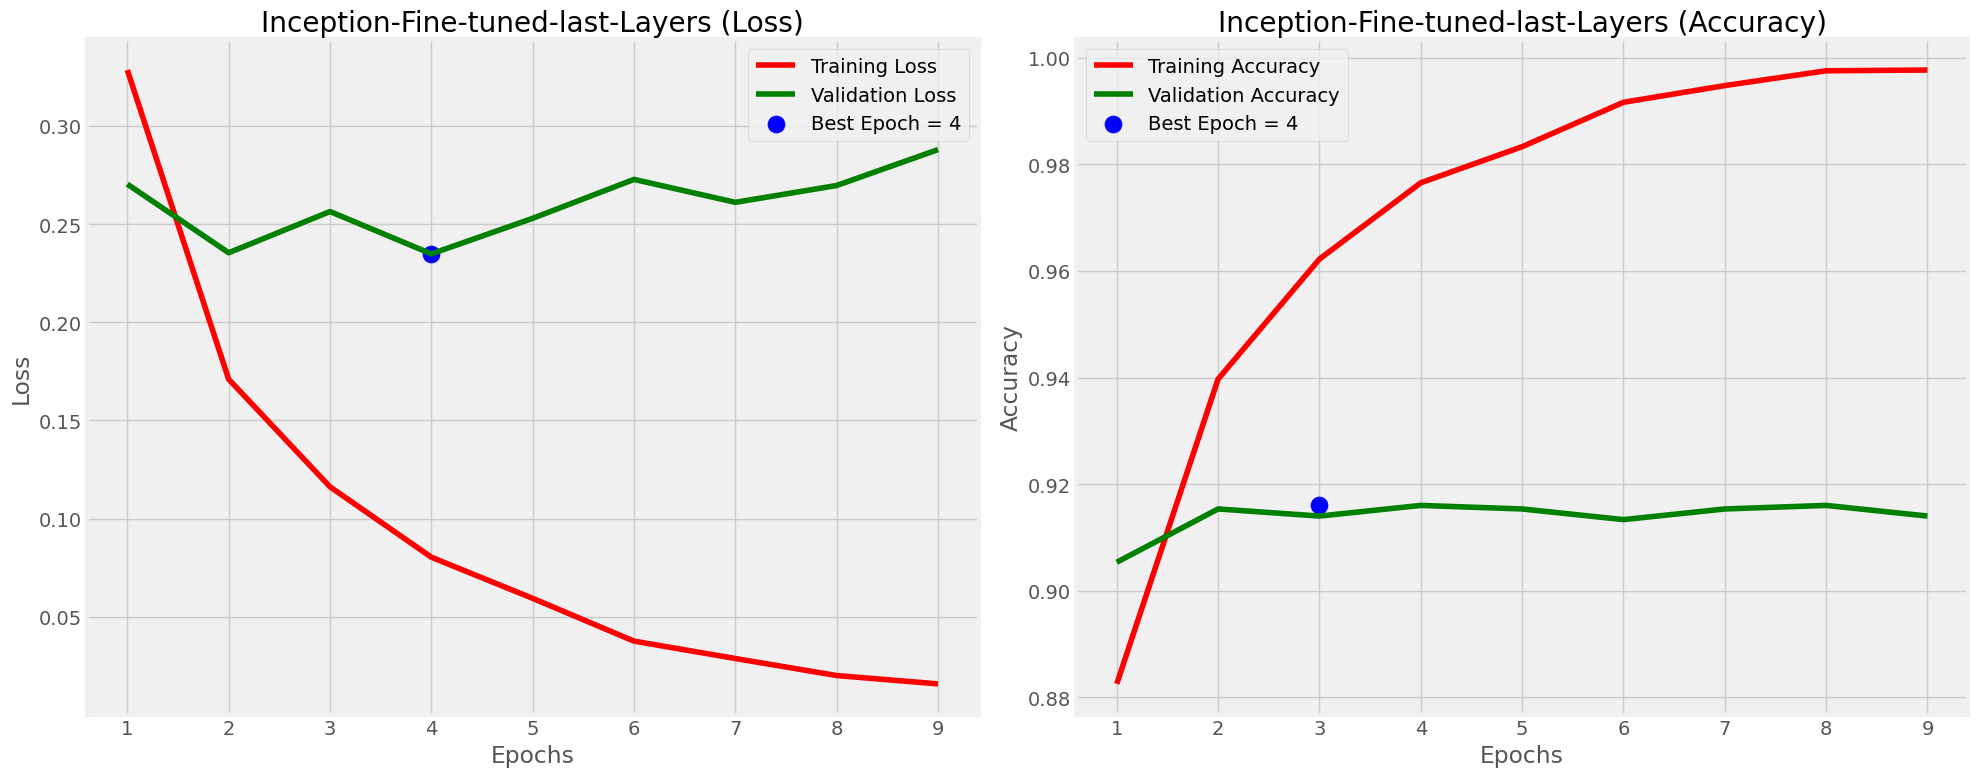

In [ ]:
plot_metrics(history4,"Inception-Fine-tuned-last-Layers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


W0000 00:00:1710593644.831446     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


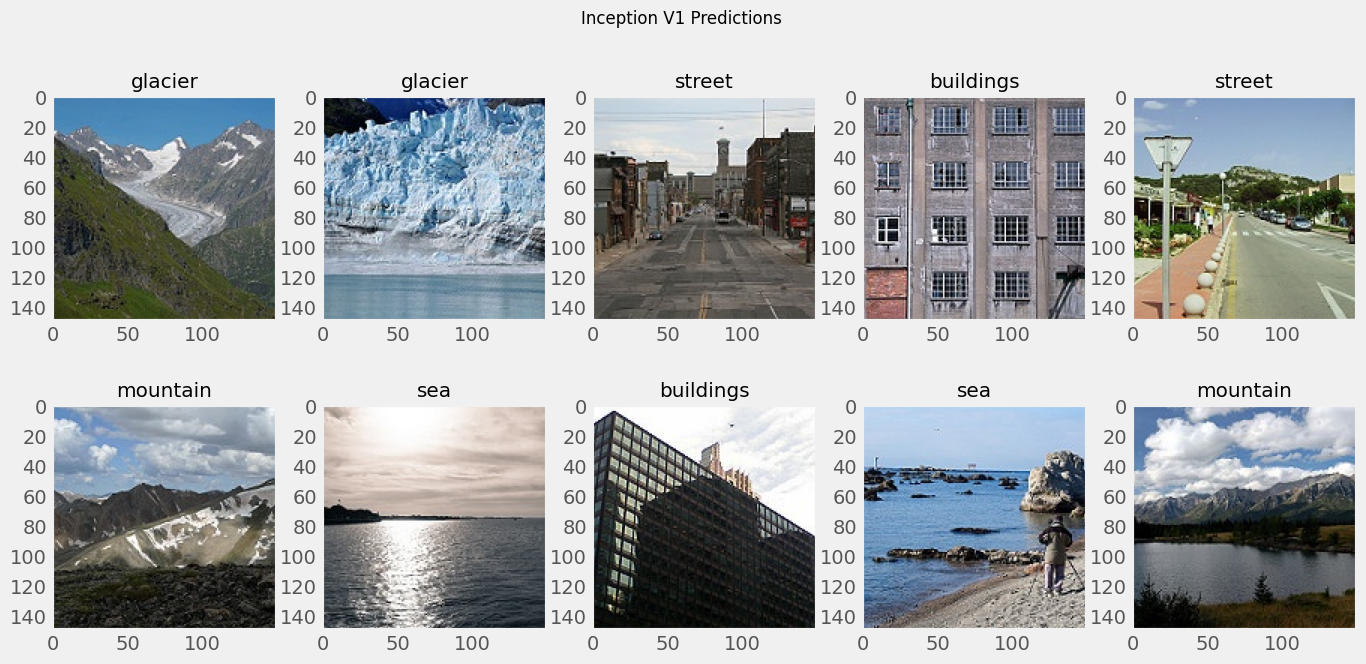

In [ ]:
plot_predictions(model4,"Inception V1 Predictions")

## V - Inception V2 :

In [ ]:
# Loading InceptionV3 pre-trained on ImageNet
inception2 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False)

# Freezing layers of the pre-trained model
for layer in inception2.layers:
    layer.trainable = False

# Unfreezing the first 25 layers for fine-tuning
for layer in inception2.layers[25:]:
    layer.trainable = True

last_layer2 = inception2.get_layer('mixed7')
last_output2 = last_layer2.output

# Adding custom classification architecture
x2 = layers.Flatten()(last_output2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)
pred2=layers.Dense(classes,activation="softmax")(x2)
# Create the fine-tuned model
model5 = models.Model(inputs=inception2.input, outputs=pred2)

In [ ]:
# compile the model
model5.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history5 = model5.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
  2/439 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - accuracy: 0.1797 - loss: 1.8468  

W0000 00:00:1710593707.297492     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8081 - loss: 0.5228

W0000 00:00:1710593762.243941     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710593767.954377     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710593772.263101     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 115s 149ms/step - accuracy: 0.8082 - loss: 0.5224 - val_accuracy: 0.9143 - val_loss: 0.2340
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.9505 - loss: 0.1396 - val_accuracy: 0.9190 - val_loss: 0.2266
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.9845 - loss: 0.0542 - val_accuracy: 0.9170 - val_loss: 0.2398
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.9950 - loss: 0.0250 - val_accuracy: 0.9203 - val_loss: 0.2655
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.9964 - loss: 0.0168 - val_accuracy: 0.9193 - val_loss: 0.2872
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 0.9173 - val_loss: 0.3076
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9223 - val_loss: 0.3180


In [ ]:
model5.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9115 - loss: 0.2593


[0.22663000226020813, 0.9190000295639038]

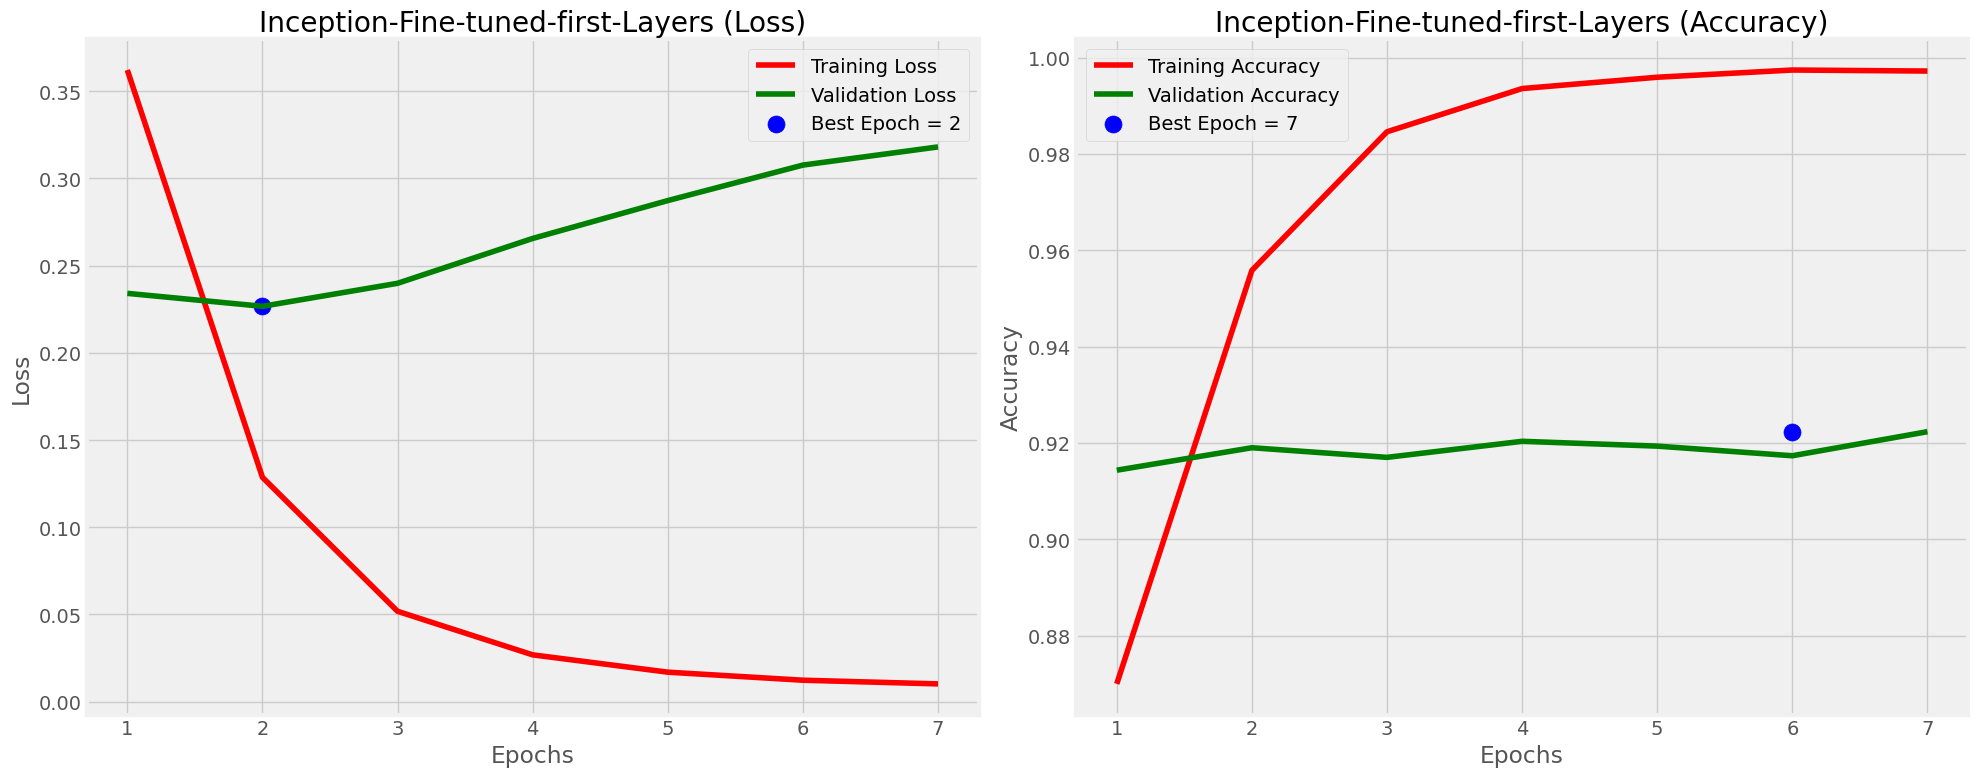

In [ ]:
plot_metrics(history5,"Inception-Fine-tuned-first-Layers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1710593977.205356     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


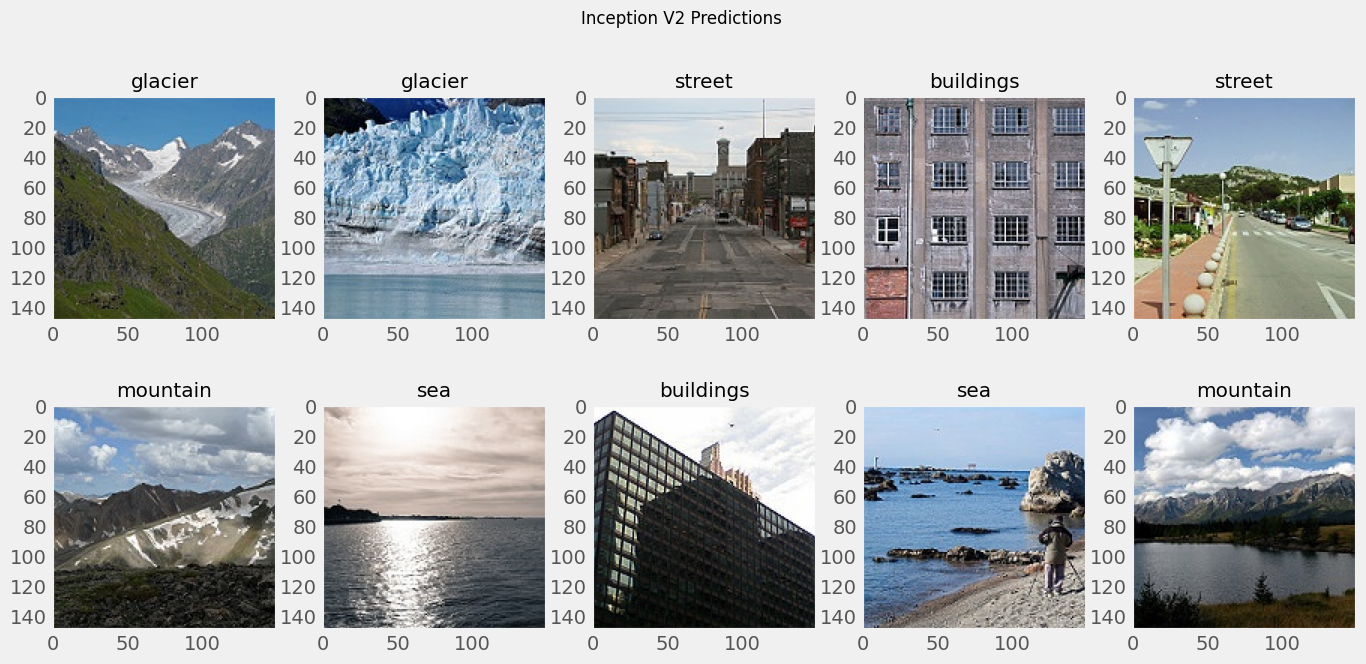

In [ ]:
plot_predictions(model5,"Inception V2 Predictions")

## VI - Inception V3

In [ ]:
# Load InceptionV3 pre-trained on ImageNet
inception3 = InceptionV3(input_shape=train_images[0].shape, weights='imagenet', include_top=False, pooling= 'max')

model6 = Sequential([
    inception3,
    layers.BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    layers.Dense(256 , activation= 'relu'),
    layers.Dense(128 , activation= 'relu'),
    layers.Dense(6 , activation= 'softmax')
])

In [ ]:
# compile the model
model6.compile(tf.keras.optimizers.Adamax(learning_rate= 0.0001) ,
               loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history6 = model6.fit(train_images, train_lab_encoded, epochs=20,
                      validation_data=(test_images, test_lab_encoded),
                      callbacks=[early])

Epoch 1/20
  1/439 ━━━━━━━━━━━━━━━━━━━━ 8:44:29 72s/step - accuracy: 0.1875 - loss: 1.9789

W0000 00:00:1710594062.045260     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6753 - loss: 0.8757

W0000 00:00:1710594141.696710     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710594150.282537     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710594158.053245     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 168s 220ms/step - accuracy: 0.6756 - loss: 0.8750 - val_accuracy: 0.8847 - val_loss: 0.3194
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.9071 - loss: 0.2750 - val_accuracy: 0.8997 - val_loss: 0.2718
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.9404 - loss: 0.1768 - val_accuracy: 0.8997 - val_loss: 0.2861
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9614 - loss: 0.1223 - val_accuracy: 0.9063 - val_loss: 0.2678
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - accuracy: 0.9730 - loss: 0.0852 - val_accuracy: 0.9080 - val_loss: 0.2798
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - accuracy: 0.9816 - loss: 0.0578 - val_accuracy: 0.9090 - val_loss: 0.2892
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.9844 - loss: 0.0489 - val_accuracy: 0.9120 - val_loss: 0.3102
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.9875 - loss: 0.0386 - va

In [ ]:
model6.evaluate(test_images, test_lab_encoded)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8910 - loss: 0.2989


[0.26784905791282654, 0.906333327293396]

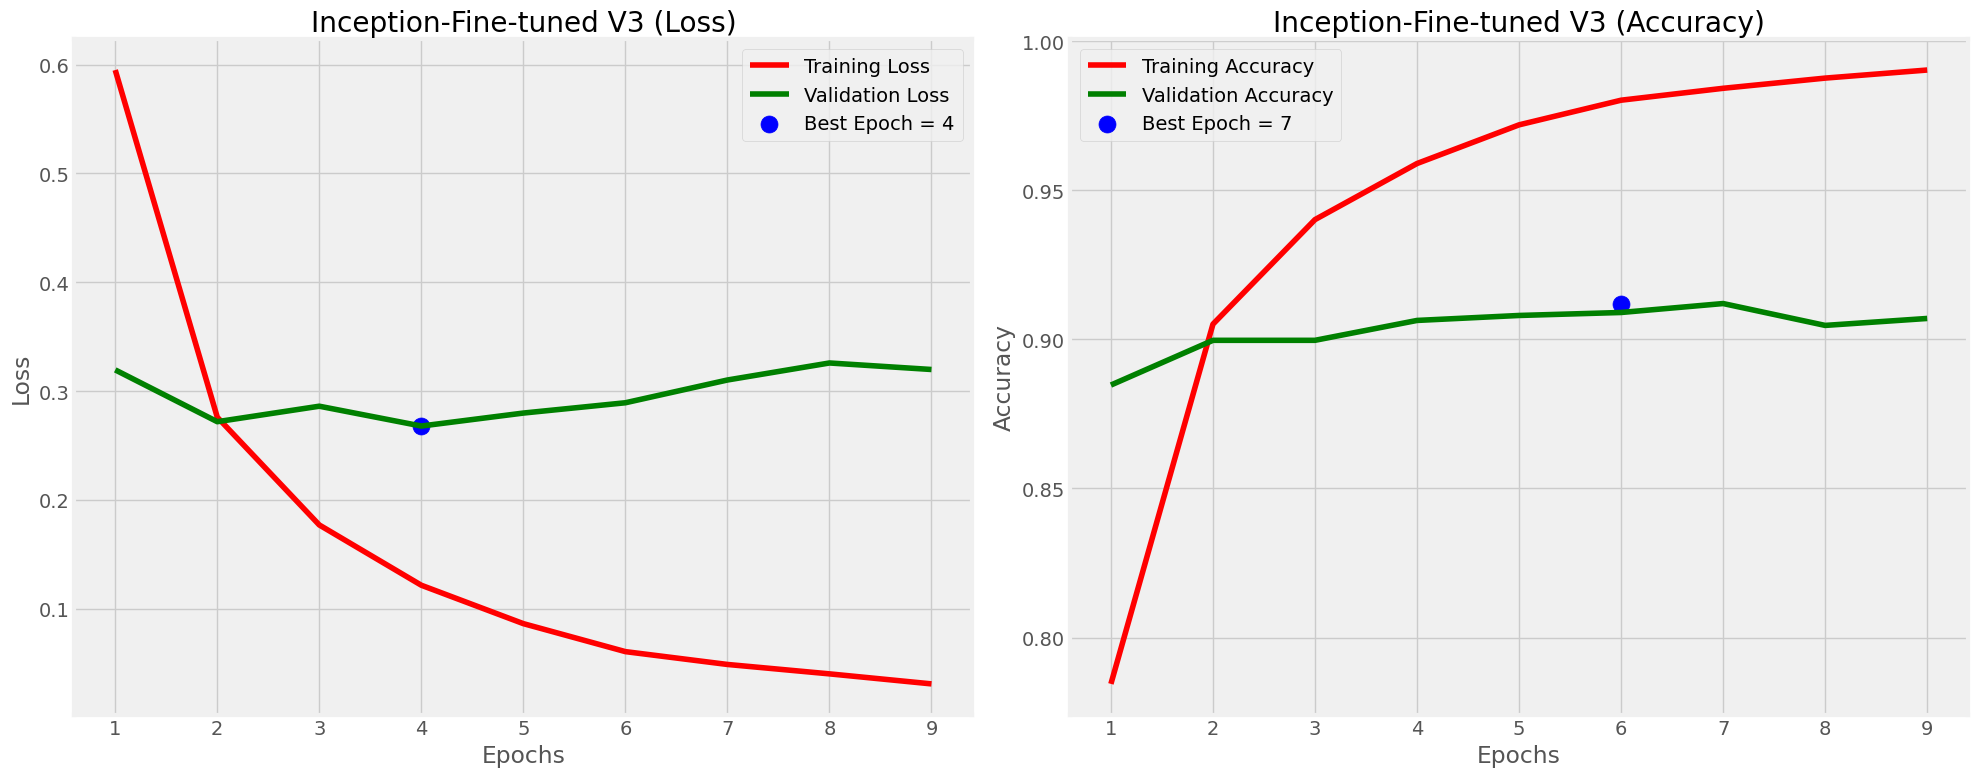

In [ ]:
plot_metrics(history6,"Inception-Fine-tuned V3")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


W0000 00:00:1710594544.585058     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


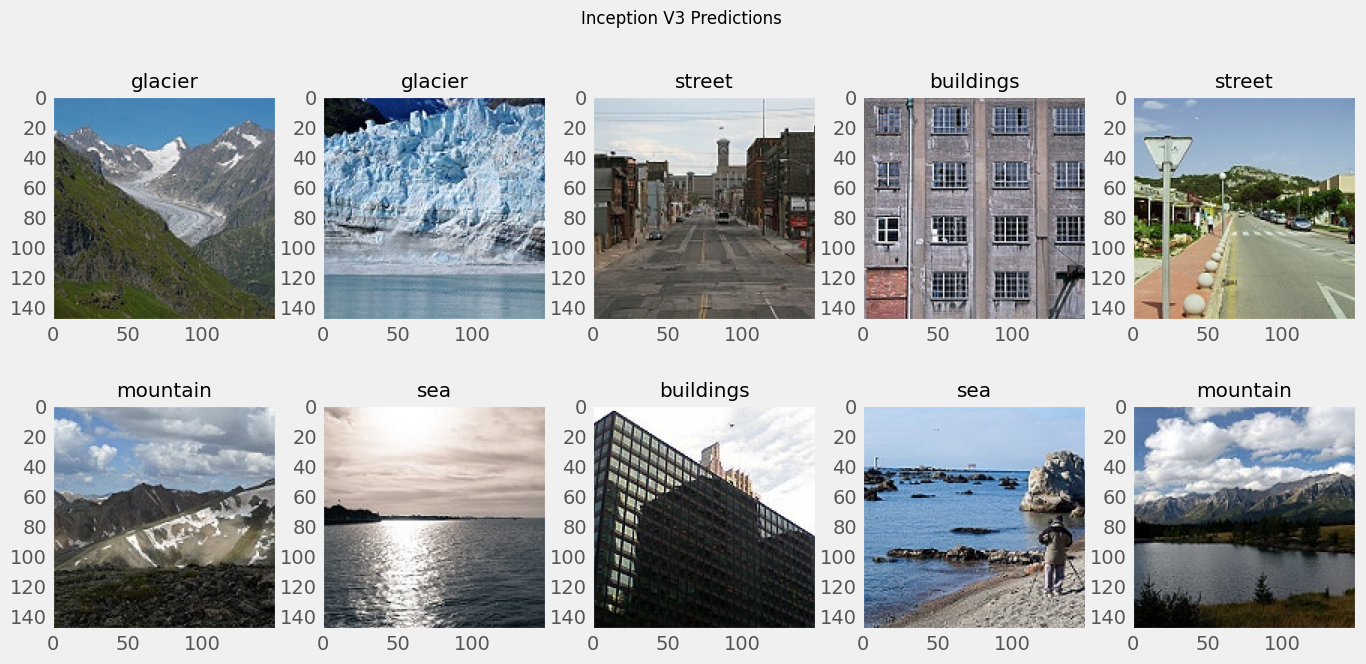

In [ ]:
plot_predictions(model6,"Inception V3 Predictions")

# Comparing Models Performances :

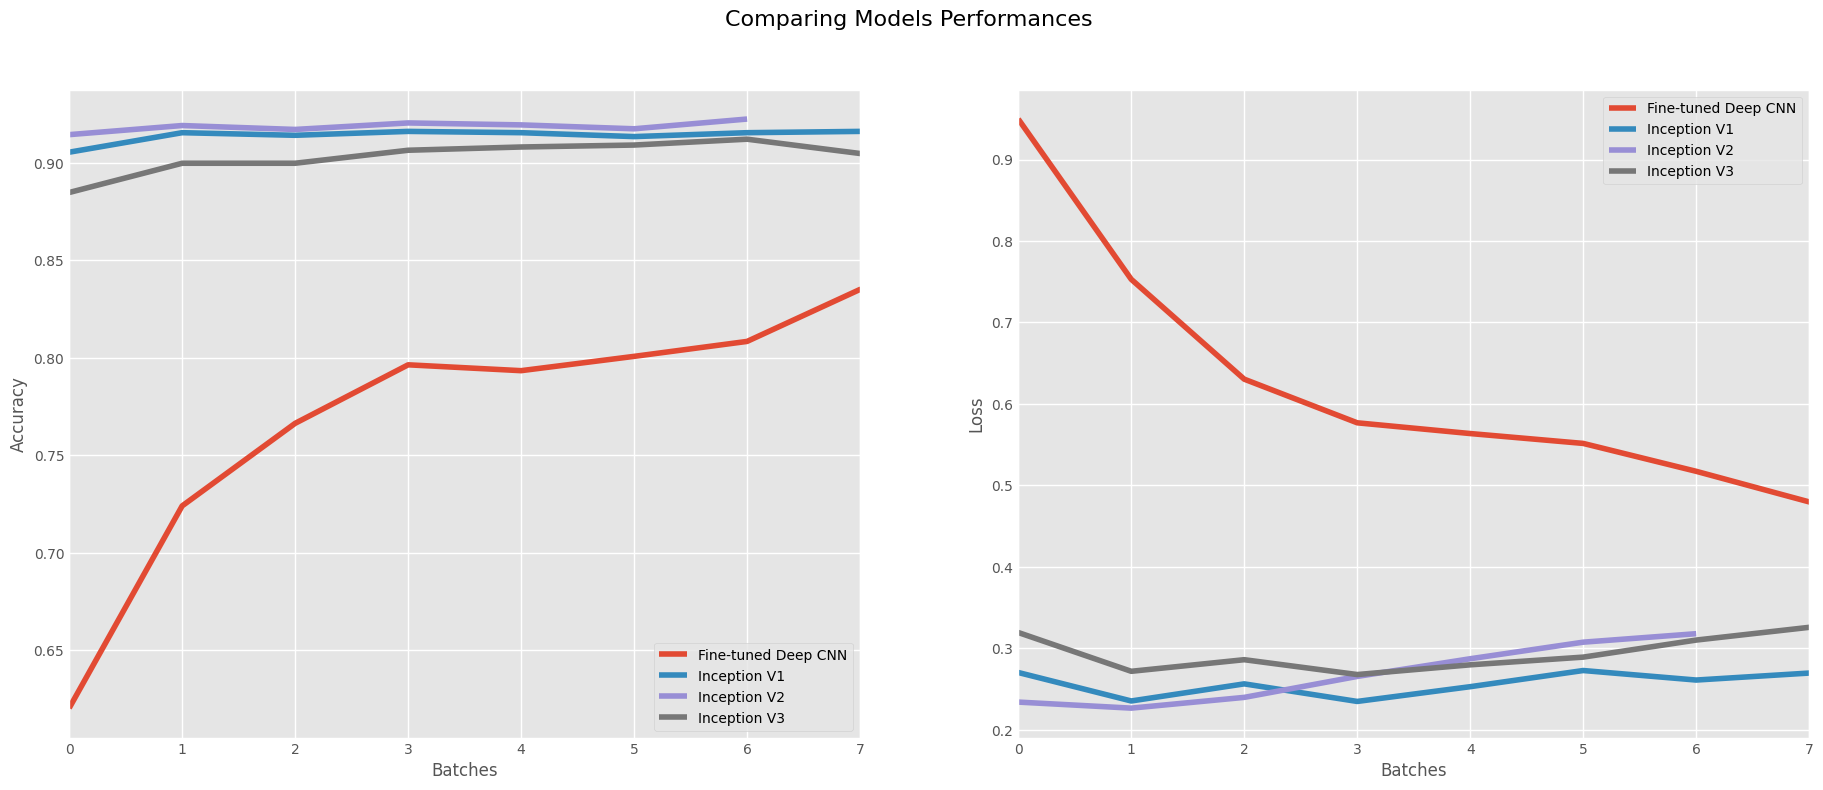

In [ ]:
history = [history3,history4,history5,history6]
labels = ["Fine-tuned Deep CNN","Inception V1", "Inception V2", "Inception V3"]
compare_models(history,labels)

34/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1710594549.627385     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
33/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1710594551.972177     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
35/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1710594554.373210     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


W0000 00:00:1710594555.074245     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

W0000 00:00:1710594560.472024     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


W0000 00:00:1710594564.662079     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

W0000 00:00:1710594569.869721     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step


W0000 00:00:1710594573.727447     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/94 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

W0000 00:00:1710594581.060504     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


W0000 00:00:1710594586.725746     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


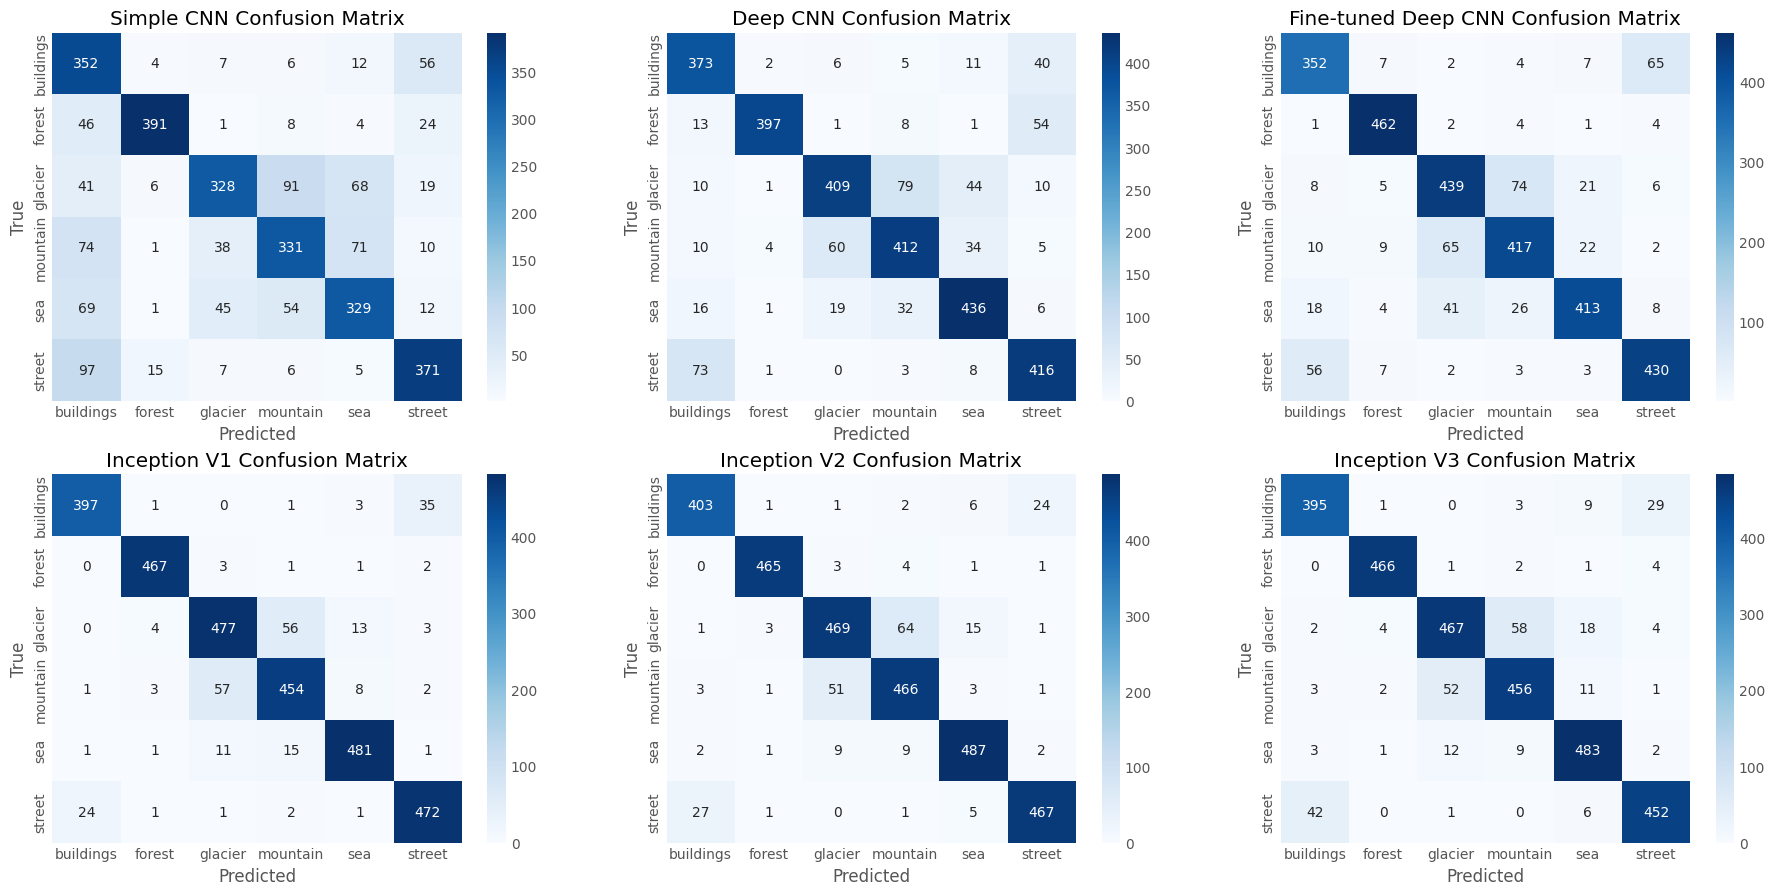

In [ ]:
models = [model1,model2,model3,model4,model5,model6]
titles = ["Simple CNN","Deep CNN","Fine-tuned Deep CNN","Inception V1", "Inception V2", "Inception V3"]
compare_conf_mat(models,test_images,test_lab_encoded,titles)

# Saving Models

In [ ]:
# saving our model
model1.save('simple_cnn.h5')
model2.save('deep_cnn.h5')
model3.save('ft_deep_cnn.h5')
model4.save('inception_v1.h5')
model5.save('inception_v2.h5')

In [ ]:
model6.save('new_inceptionv3.h5')

ValueError: Unable to synchronously create dataset (name already exists)